https://www.meetup.com/PyData-PDX/events/280454606

http://xarray.pydata.org/en/stable/

https://sites.google.com/view/raybellwaves/cheat-sheets/xarray

https://github.com/pydata/xarray/discussions

https://discourse.pangeo.io/

# Let's learn xarray by answering some questions with weather data:

 - Q1. How hot did it get in Portland, Oregeon this summer?
 - Q2. How much hotter was that compared to last year?
 - Q3. During the peak of the heatwave where else in the world was hotter than Portland?

# Get a temperature dataset for Portland (xarray advanced)

In [1]:
files = []

import xarray as xr

for dt in xr.cftime_range("2020-01", "2021-08", freq="M"):
    files.append(
        f"s3://era5-pds/zarr/{dt:%Y}/{dt:%m}/data/air_temperature_at_2_metres.zarr"
    )

from geopy.geocoders import Photon

geolocator = Photon()
location = geolocator.geocode("Portland, Oregon")
print(location)
lat = location.point.latitude
lon = location.point.longitude + 360
print(lat, lon)


def select_location(ds: xr.Dataset) -> xr.Dataset:
    return ds.sel(lat=lat, lon=lon, method="nearest")


import cf_xarray.units
import pint_xarray
from tqdm.dask import TqdmCallback

TqdmCallback(desc="dask tasks").register()

portland_ds = (
    xr.open_mfdataset(
        files,
        engine="zarr",
        backend_kwargs=dict(storage_options={"anon": True}),
        parallel=True,
        preprocess=select_location,
    )
    .compute()
    .pint.quantify()
    .pint.to("degF")
)
portland_ds = portland_ds.pint.dequantify(format="~P")

from timezonefinder import TimezoneFinder

tz = TimezoneFinder().timezone_at(lng=location.point.longitude, lat=lat)
print(tz)
import cf_xarray

time_dim_name = portland_ds.cf["time"].name
time_dim_attrs = portland_ds.cf["time"].attrs
portland_ds = portland_ds.assign_coords(
    {
        time_dim_name: portland_ds[time_dim_name]
        .to_index()
        .tz_localize("UTC")
        .tz_convert(tz)
        .tz_localize(None)
        .to_numpy()
    }
)
portland_ds[time_dim_name].attrs = time_dim_attrs

Portland, Oregon, United States
45.5202471 237.3258051


dask tasks:   0%|          | 0/57 [00:00<?, ?it/s]

dask tasks:   0%|          | 0/76 [00:00<?, ?it/s]

America/Los_Angeles


In [2]:
type(portland_ds)

xarray.core.dataset.Dataset

http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html

In [3]:
portland_ds

<xarray.Dataset>
Dimensions:                      (time0: 13872)
Coordinates:
    lat                          float32 45.5
    lon                          float32 237.2
  * time0                        (time0) datetime64[ns] 2019-12-31T16:00:00 ....
Data variables:
    air_temperature_at_2_metres  (time0) float32 48.72 48.72 ... 81.12 81.0
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

Firstly, you can transform the data to a format you are more familar with:

In [4]:
df = portland_ds.reset_coords(drop=True).to_dataframe()
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


air_temperature_at_2_metres
time0                                           
2019-12-31 16:00:00                    48.717495
2019-12-31 17:00:00                    48.717495
2019-12-31 18:00:00                    48.942497
2019-12-31 19:00:00                    49.392498
2019-12-31 20:00:00                    49.729996
...                                          ...
2021-07-31 12:00:00                    78.867493
2021-07-31 13:00:00                    80.554993
2021-07-31 14:00:00                    82.242493
2021-07-31 15:00:00                    81.117493
2021-07-31 16:00:00                    81.004997

[13872 rows x 1 columns]

In [5]:
arr = portland_ds["air_temperature_at_2_metres"].values
print(type(arr))
arr

<class 'numpy.ndarray'>


array([48.717495, 48.717495, 48.942497, ..., 82.24249 , 81.11749 ,
       81.005   ], dtype=float32)

You can also do the inverse of the transformations:

In [6]:
df.to_xarray()

<xarray.Dataset>
Dimensions:                      (time0: 13872)
Coordinates:
  * time0                        (time0) datetime64[ns] 2019-12-31T16:00:00 ....
Data variables:
    air_temperature_at_2_metres  (time0) float32 48.72 48.72 ... 81.12 81.0

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_xarray.html

In [7]:
da = xr.DataArray(arr)
da

<xarray.DataArray (dim_0: 13872)>
array([48.717495, 48.717495, 48.942497, ..., 82.24249 , 81.11749 ,
       81.005   ], dtype=float32)
Dimensions without coordinates: dim_0

http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html

In [8]:
da.to_dataset(name="arr")

<xarray.Dataset>
Dimensions:  (dim_0: 13872)
Dimensions without coordinates: dim_0
Data variables:
    arr      (dim_0) float32 48.72 48.72 48.94 49.39 ... 80.55 82.24 81.12 81.0

# Q1. How hot did it get in Portland, Oregeon this summer?

Visualize the data using xarray's plotting capability (http://xarray.pydata.org/en/stable/user-guide/plotting.html):

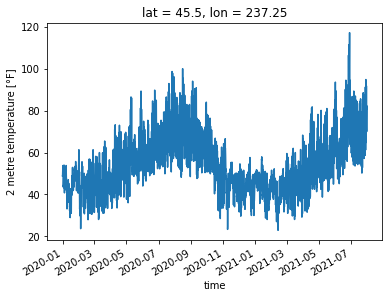

In [9]:
portland_ds["air_temperature_at_2_metres"].plot()

Create a quick interactive plot using hvplot (https://hvplot.holoviz.org/)

In [10]:
import hvplot.xarray

portland_ds.hvplot()

:Curve   [time0]   (air_temperature_at_2_metres)

In [11]:
portland_ds.max()

<xarray.Dataset>
Dimensions:                      ()
Coordinates:
    lat                          float32 45.5
    lon                          float32 237.2
Data variables:
    air_temperature_at_2_metres  float32 117.2

Query a Dataset on a value

In [12]:
hot_ds = portland_ds.where(portland_ds == portland_ds.max(), drop=True)
hot_ds

<xarray.Dataset>
Dimensions:                      (time0: 1)
Coordinates:
    lat                          float32 45.5
    lon                          float32 237.2
  * time0                        (time0) datetime64[ns] 2021-06-28T18:00:00
Data variables:
    air_temperature_at_2_metres  (time0) float32 117.2
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

## A1. How hot did it get in Portland, Oregeon this summer?

In [13]:
ts = hot_ds["time0"].to_index().tz_localize(tz).to_pydatetime()[0]
max_temp = hot_ds["air_temperature_at_2_metres"].values[0]
units = hot_ds["air_temperature_at_2_metres"].attrs["units"]
print(
    f"The max tempetaure in Portland, Oregeon this summer was {max_temp:.2f} {units} on {ts}"
)

The max tempetaure in Portland, Oregeon this summer was 117.23 °F on 2021-06-28 18:00:00-07:00


# Q2. How much hotter was that compared to last year?

In [14]:
da = portland_ds["air_temperature_at_2_metres"]
da

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 13872)>
array([48.717495, 48.717495, 48.942497, ..., 82.24249 , 81.11749 ,
       81.005   ], dtype=float32)
Coordinates:
    lat      float32 45.5
    lon      float32 237.2
  * time0    (time0) datetime64[ns] 2019-12-31T16:00:00 ... 2021-07-31T16:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

In [15]:
g = da.groupby("time0.year").max()
g

<xarray.DataArray 'air_temperature_at_2_metres' (year: 3)>
array([ 50.854996, 100.017494, 117.229996], dtype=float32)
Coordinates:
    lat      float32 45.5
    lon      float32 237.2
  * year     (year) int64 2019 2020 2021

http://xarray.pydata.org/en/stable/user-guide/groupby.html

In [16]:
g.sel(year=2021) - g.sel(year=2020)

<xarray.DataArray 'air_temperature_at_2_metres' ()>
array(17.212502, dtype=float32)
Coordinates:
    lat      float32 45.5
    lon      float32 237.2

http://xarray.pydata.org/en/stable/user-guide/indexing.html?highlight=indexing

## A2. How much hotter was that compared to last year?

In [17]:
diff = (g.sel(year=2021) - g.sel(year=2020)).values

from sklearn.metrics import mean_absolute_percentage_error

mape = (
    mean_absolute_percentage_error(
        [g.sel(year=2021).to_numpy()],
        [g.sel(year=2020).to_numpy()],
    )
    * 100
)

print(f"The peak temeperature different between 2021 and 2020 was {diff:.2f} {units}")
print(f"That's {mape:.2f} percent hotter")

The peak temeperature different between 2021 and 2020 was 17.21 °F
That's 14.68 percent hotter


# Q3. During the peak of the heatwave where else in the world was hotter than Portland?

In [18]:
import pytz

dt_utc = ts.astimezone(pytz.timezone("UTC")).replace(tzinfo=None)

da_ts = (
    xr.open_zarr(
        f"s3://era5-pds/zarr/{dt_utc:%Y}/{dt_utc:%m}/data/air_temperature_at_2_metres.zarr",
        storage_options={"anon": True},
    )["air_temperature_at_2_metres"].sel(time0=dt_utc)
).compute()
da_ts

dask tasks:   0%|          | 0/100 [00:00<?, ?it/s]

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
array([[273.875 , 273.875 , 273.875 , ..., 273.875 , 273.875 , 273.875 ],
       [273.9375, 273.9375, 273.9375, ..., 273.9375, 273.9375, 273.9375],
       [273.9375, 273.9375, 273.9375, ..., 273.9375, 273.9375, 273.9375],
       ...,
       [227.75  , 227.75  , 227.75  , ..., 227.75  , 227.75  , 227.75  ],
       [227.25  , 227.25  , 227.3125, ..., 227.25  , 227.25  , 227.25  ],
       [225.75  , 225.75  , 225.75  , ..., 225.75  , 225.75  , 225.75  ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    time0    datetime64[ns] 2021-06-29T01:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

Convert degrees Kelvin to degrees Fahrenheit using https://pint-xarray.readthedocs.io/en/latest/

In [19]:
da_ts = da_ts.pint.quantify().pint.to("degF").pint.dequantify(format="~P")

Convert longitude from 0 - 360 to -180 - 180

In [20]:
with xr.set_options(keep_attrs=True):
    da_ts = da_ts.assign_coords({"lon": (((da_ts["lon"] + 180) % 360) - 180)}).sortby(
        "lon"
    )

Reindex latitude to from 90 - -90 to -90 - 90 

In [21]:
da_ts = da_ts.reindex({"lat": da_ts["lat"][::-1]})
da_ts

<xarray.DataArray 'air_temperature_at_2_metres' (lat: 721, lon: 1440)>
array([[-53.32    , -53.32    , -53.32    , ..., -53.32    , -53.32    ,
        -53.32    ],
       [-56.019997, -56.019997, -56.019997, ..., -56.019997, -56.019997,
        -56.019997],
       [-57.37    , -57.37    , -57.37    , ..., -57.4825  , -57.4825  ,
        -57.4825  ],
       ...,
       [ 33.079998,  33.079998,  33.079998, ...,  33.079998,  33.079998,
         33.079998],
       [ 33.079998,  33.079998,  33.079998, ...,  33.079998,  33.079998,
         33.079998],
       [ 33.304996,  33.304996,  33.304996, ...,  33.304996,  33.304996,
         33.304996]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
    time0    datetime64[ns] 2021-06-29T01:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

Check the data was read in correctly:

In [22]:
da_ts.sel(lat=lat, lon=lon - 360, method="nearest")

<xarray.DataArray 'air_temperature_at_2_metres' ()>
array(117.229996, dtype=float32)
Coordinates:
    lat      float32 45.5
    lon      float32 -122.8
    time0    datetime64[ns] 2021-06-29T01:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

Plot the spatial data using cartopy:

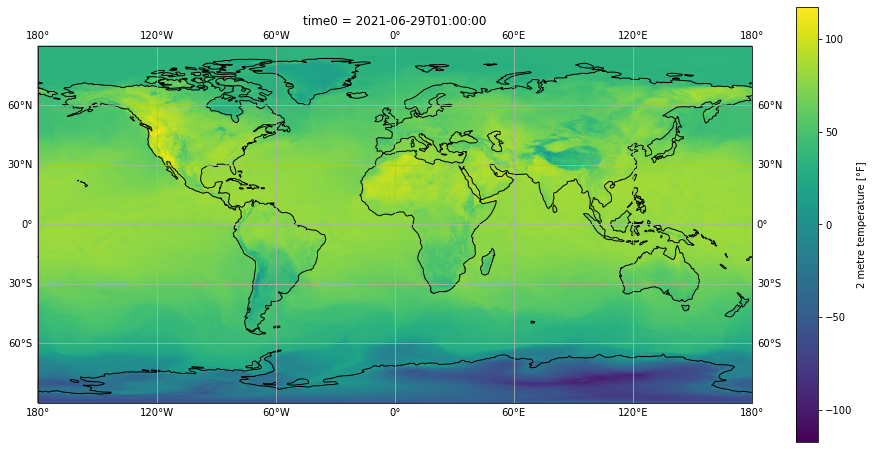

In [23]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
ax = plt.subplot(projection=ccrs.PlateCarree())
da_ts.plot(ax=ax, cmap=plt.cm.viridis)
ax.coastlines()
ax.gridlines(draw_labels=True);

Create an interactive map using Geoviews https://geoviews.org/index.html

In [24]:
import geoviews as gv

gv_da_ts = gv.Dataset(da_ts)
gv_img = gv_da_ts.to(gv.Image, kdims=["lon", "lat"])

from holoviews.operation.datashader import rasterize

gv_raster = rasterize(gv_img)

# Download a populous city dataset
import geopandas as gpd

cities = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_populated_places.zip"
)[["NAME", "geometry"]]
gv_pts = gv.Points(cities)

# Overlay layers: raster (temperature), coastlines, country boarders, state boarders, capital cities
# with custom plotting options
import geoviews.feature as gf

gv_raster.opts(
    tools=["hover"],
    width=1000,
    height=600,
    cmap=plt.cm.viridis.name,
    colorbar=True,
    colorbar_position="right",
) * gf.coastline() * gf.borders() * gf.states(color=None) * gv_pts.opts(
    tools=["hover"], color="black", size=2
)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:DynamicMap   []
   :Overlay
      .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
      .States.I    :Feature   [Longitude,Latitude]
      .Points.I    :Points   [Longitude,Latitude]   (NAME)

Flatten the 2d array to 1d

In [25]:
da_ts_1d = da_ts.stack({"point": ["lat", "lon"]})
da_ts_1d

<xarray.DataArray 'air_temperature_at_2_metres' (point: 1038240)>
array([-53.32    , -53.32    , -53.32    , ...,  33.304996,  33.304996,
        33.304996], dtype=float32)
Coordinates:
    time0    datetime64[ns] 2021-06-29T01:00:00
  * point    (point) MultiIndex
  - lat      (point) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  - lon      (point) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

sort values

In [26]:
da_ts_1d_sorted = da_ts_1d.sortby(da_ts_1d)
da_ts_1d_sorted

<xarray.DataArray 'air_temperature_at_2_metres' (point: 1038240)>
array([-99.445   , -99.3325  , -99.3325  , ..., 116.77999 , 116.892494,
       117.229996], dtype=float32)
Coordinates:
    time0    datetime64[ns] 2021-06-29T01:00:00
  * point    (point) MultiIndex
  - lat      (point) float64 -77.5 -77.5 -77.5 -77.25 ... 46.5 45.75 45.5 45.5
  - lon      (point) float64 105.5 105.2 105.8 104.8 ... -119.8 -122.5 -122.8
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

Keep values greater than the temperature in portland

In [27]:
da_ts_1d_sorted.where(da_ts_1d_sorted >= max_temp, drop=True)

<xarray.DataArray 'air_temperature_at_2_metres' (point: 1)>
array([117.229996], dtype=float32)
Coordinates:
    time0    datetime64[ns] 2021-06-29T01:00:00
  * point    (point) MultiIndex
  - lat      (point) float64 45.5
  - lon      (point) float64 -122.8
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

In [28]:
points_hotter_than_portland = da_ts_1d_sorted.where(
    da_ts_1d_sorted >= max_temp, drop=True
)
points_hotter_than_portland

<xarray.DataArray 'air_temperature_at_2_metres' (point: 1)>
array([117.229996], dtype=float32)
Coordinates:
    time0    datetime64[ns] 2021-06-29T01:00:00
  * point    (point) MultiIndex
  - lat      (point) float64 45.5
  - lon      (point) float64 -122.8
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           °F

## A3. During the peak of the heatwave where else in the world was hotter than Portland?

In [29]:
locs = []
for p in points_hotter_than_portland["point"].values:
    loc = geolocator.reverse(p)
    if "Portland" not in str(loc):
        locs.append(loc)
if len(locs) == 0:
    print("Nowhere!")

Nowhere!
